### 1. Importing dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

### 2. Reading the dataset and preprocessing

In [2]:
recipes = pd.read_json("../../data/eda_receitas_data/receitas.json")

In [3]:
recipes.shape

(20130, 11)

A lot of missing data could harm the analysis.

In [4]:
recipes.isnull().sum()

directions       19
fat            4222
date             19
categories       19
calories       4154
desc           6635
protein        4201
rating           30
title            19
ingredients      19
sodium         4156
dtype: int64

Make sure all null values are of type 'np.nan' to further correctly address imputing.

In [5]:
recipes.fillna(value=np.nan, inplace=True)

The 19 recipes with no date associated are dropped as we cannot infer properly when they were created and it my impact analysis. These samples are not proportionally relevant and can be dropped.

In [6]:
recipes = recipes.drop(index=recipes[recipes.date.isnull() == True].index)

In [7]:
recipes.shape

(20111, 11)

All numerical features but 'rating' have pretty high standard deviations as various samples are too far from the mean.

In [8]:
recipes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fat,15908.0,346.097498,20431.020991,0.0,7.00,17.000,33.000,1722763.0
calories,15976.0,6307.856848,358585.122970,0.0,198.00,331.000,586.000,30111218.0
protein,15929.0,99.946199,3835.616663,0.0,3.00,8.000,27.000,236489.0
rating,20100.0,3.713060,1.343144,0.0,3.75,4.375,4.375,5.0
sodium,15974.0,6211.473832,332890.254083,0.0,80.00,294.000,711.000,27675110.0


Now let's address missing values with imputing.

In [9]:
recipes.isnull().sum()

directions        0
fat            4203
date              0
categories        0
calories       4135
desc           6616
protein        4182
rating           11
title             0
ingredients       0
sodium         4137
dtype: int64

In [10]:
recipes.dtypes

directions                  object
fat                        float64
date           datetime64[ns, UTC]
categories                  object
calories                   float64
desc                        object
protein                    float64
rating                     float64
title                       object
ingredients                 object
sodium                     float64
dtype: object

#### 2.1 Defining column transformer for impute missing data according to the columns data type. 

In [11]:
NUMERICAL_FEATURES = recipes.select_dtypes(include='float64').columns.tolist()
STRING_FEATURES = recipes.select_dtypes(include='object').columns.tolist()
DATE_FEATURE = recipes.select_dtypes(include='datetime64[ns, UTC]').columns.tolist()

In [12]:
numerical_transformer = Pipeline(
    steps=[('imputer', KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'))])

In [13]:
string_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Missing'))])

In [14]:
date_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median', missing_values=np.nan))])

In [15]:
column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('str', string_transformer, STRING_FEATURES),
        ('date', date_transformer, DATE_FEATURE)
    ])

Fitting the transformer

In [16]:
recipes = pd.DataFrame(column_transformer.fit_transform(recipes))

In [17]:
recipes.columns = ['fat', 'calories', 'protein', 'rating', 'sodium', 'directions', 'categories', 'desc', 'title', 'ingredients', 'date']

In [18]:
recipes.date = pd.to_datetime(recipes.date, infer_datetime_format=True)

Dataset is now clean and ready for analysis.

In [19]:
recipes.isnull().sum()

fat            0
calories       0
protein        0
rating         0
sodium         0
directions     0
categories     0
desc           0
title          0
ingredients    0
date           0
dtype: int64

In [20]:
recipes.sample(5)

,fat,calories,protein,rating,sodium,directions,categories,desc,title,ingredients,date
15985,10.0,228.0,6.0,0.0,269.0,"[Stir the flour, sugar, and the salt together ...","[Bread, Dairy, Egg, Bake]",Missing,Simple Brioche,"[3 cups unbleached, all-purpose flour, 1/4 cup...",2004-08-20 04:00:00
6308,14.0,192.0,5.0,3.75,1134.0,[Blanch brussels sprouts in a large pot of boi...,"[Wok, Garlic, Side, Stir-Fry, Low Cal, Dinner,...","The simplest of all Thai dishes, stir-fries ar...",Stir-Fried Brussels Sprouts with Garlic and Ch...,"[4 cups halved brussels sprouts, Kosher salt, ...",2011-12-09 04:00:00
7806,9.0,167.0,7.0,3.75,622.0,[Cook bacon in heavy large skillet over medium...,"[Leafy Green, Pork, Side, Sauté, Valentine's D...",Missing,Swiss Chard and Beet Sauté,"[3 slices bacon, coarsely chopped, 1 onion, ch...",2004-08-20 04:00:00
12423,1.0,22.0,1.0,3.125,73.0,[Put oven rack in middle position and preheat ...,"[Food Processor, Cheese, Dairy, Pork, Vegetabl...",Missing,Sweet-Pea Canapes,[1 (10-ounce) box frozen baby peas (2 1/4 cups...,2007-04-17 21:24:26
5029,30.0,607.0,15.0,3.75,49.0,[Melt butter in a 12-inch heavy skillet over m...,"[Pasta, Quick & Easy, Dinner, Pine Nut, Butter...",Sweet nibbles of butternut squash temper the b...,Butternut Squash and Radicchio Pappardelle,"[1/2 stick unsalted butter, 2 tablespoon olive...",2008-12-16 04:00:00


In [21]:
recipes[NUMERICAL_FEATURES] = recipes[NUMERICAL_FEATURES].astype('float64')

In [22]:
recipes.dtypes

fat                   float64
calories              float64
protein               float64
rating                float64
sodium                float64
directions             object
categories             object
desc                   object
title                  object
ingredients            object
date           datetime64[ns]
dtype: object

In [23]:
recipes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fat,20111.0,278.327452,18171.453123,0.0,7.00,16.000,33.000,1722763.0
calories,20111.0,5099.741625,319608.758771,0.0,229.00,408.000,524.000,30111218.0
protein,20111.0,80.677807,3413.785282,0.0,4.00,7.200,19.000,236489.0
rating,20111.0,3.713085,1.342793,0.0,3.75,4.375,4.375,5.0
sodium,20111.0,5022.323211,296689.235380,0.0,102.00,382.400,571.000,27675110.0


### 3. What are the mean recipes calories, fat and protein throughout the years?

In [24]:
sorted_recipes = recipes.sort_values(by='date', ascending=True)

In [25]:
sorted_recipes.sample(5)

,fat,calories,protein,rating,sodium,directions,categories,desc,title,ingredients,date
17771,23.2,437.2,2.6,1.875,121.6,"[Lightly spray a 2 1/2-quart baking dish, 13 b...","[Cheese, Dairy, Egg, Vegetable, Bake, Low Fat,...",Accompaniment: Fresh Tomato Salsa,Onion and Bell Pepper Strata with Fresh Tomato...,"[vegetable-oil cooking spray, 1 medium onion, ...",2004-08-20 12:48:48
18571,19.0,368.0,12.0,3.125,451.0,[In a heavy saucepan cook the leek and the gar...,"[Soup/Stew, Garlic, Potato, Quick & Easy, Summ...",Can be prepared in 45 minutes or less.,Cold Garlic Potato Soup,"[3/4 cup finely chopped white part of leek, wa...",2004-08-20 04:00:00
7299,51.0,668.0,37.0,3.750,230.0,[Sprinkle pork with salt and pepper. Heat oil ...,"[Onion, Pork, Sauté, Quick & Easy, Lime, Summe...",This is great over steamed rice.,Shredded Pork Tenderloin with Lime Sauce,"[1 1/4 pounds pork tenderloin, cut into thin s...",2004-08-20 04:00:00
14842,31.0,508.0,29.0,3.750,541.0,"[In a large bowl, combine the meat, all but 2 ...","[Beef, Onion, Tomato, Sauté, Super Bowl, Fall,...","Voli are marbles, the multicolored little ball...",Meatballs with Bulgur in Onion and Tomato Sauc...,"[1 pound lean ground beef, veal, lamb or pork ...",2004-08-20 04:00:00
18946,22.0,601.0,27.0,3.750,562.0,[Heat olive oil in heavy large skillet over me...,"[Garlic, Pasta, Sauté, Quick & Easy, Scallop, ...",Missing,Seafood Linguine,"[3 tablespoons olive oil, 1/2 cup finely chopp...",2004-08-20 04:00:00


In [26]:
sorted_recipes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fat,20111.0,278.327452,18171.453123,0.0,7.00,16.000,33.000,1722763.0
calories,20111.0,5099.741625,319608.758771,0.0,229.00,408.000,524.000,30111218.0
protein,20111.0,80.677807,3413.785282,0.0,4.00,7.200,19.000,236489.0
rating,20111.0,3.713085,1.342793,0.0,3.75,4.375,4.375,5.0
sodium,20111.0,5022.323211,296689.235380,0.0,102.00,382.400,571.000,27675110.0


In [27]:
def plot_evolution(feature, ax):    
    data = pd.concat([sorted_recipes.date, sorted_recipes[feature]], axis=1)
    data['counter'] = range(1, len(data)+1, 1)
    data = data.rename(columns={feature: 'AVERAGE ' + feature})
    data['AVERAGE ' + feature] = data['AVERAGE ' + feature].cumsum() / data.counter
    sns.lineplot(data=data, x='date', y='AVERAGE ' + feature, ax=ax)

All features mean converge to the described value. There is a direct relationship between fat and calorie

Ratings mean increase in the first years and maintain close to 3.7 from 2005 till 2016.

<Axes: >

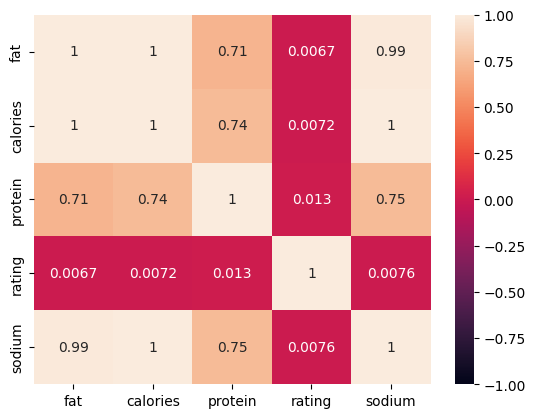

In [28]:
sns.heatmap(sorted_recipes.corr(numeric_only=True), annot=True, vmin=-1, vmax=1)

We can see from both lineplot and correlation heatmap how strongly related are 'fat' and 'calories'.

It is also important to highlight that effectively sodium varies according to fat as well. In general, protein quantities in recipes influence in the final amount of calorical properties in the food.

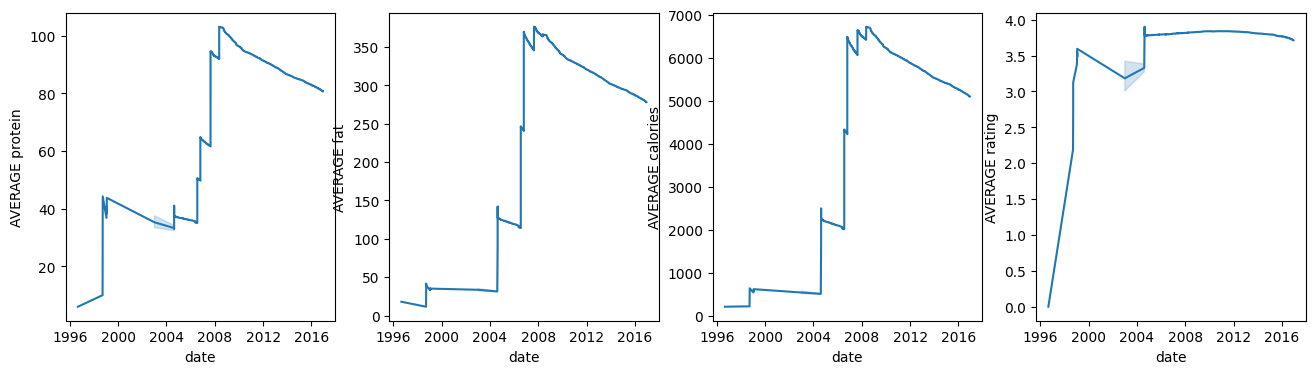

In [29]:
fig, ax = plt.subplots(figsize=(16,4), ncols=4)

plot_evolution('protein', ax[0])
plot_evolution('fat', ax[1])
plot_evolution('calories', ax[2])
plot_evolution('rating', ax[3])

### 4. Plot histograms for the numerical variables

As the standard deviaton for some features are too high, in order to plot the histograms we are using unsupervised outlier detection to visualize the remaining recipes that have values closer their mean.

In [30]:
nums_scaled = pd.DataFrame(MinMaxScaler().fit_transform(sorted_recipes[NUMERICAL_FEATURES]))

In [31]:
lof = LocalOutlierFactor(n_neighbors=20).fit(nums_scaled)

In [32]:
outliers_preds = lof.fit_predict(nums_scaled)
pd.DataFrame(outliers_preds).value_counts()

 1    19147
-1      964
dtype: int64

Filtering only the recipes considered not outliers, excluding the ones too much calorical, with too much sodium and fat, ect.

In [33]:
sorted_recipes = sorted_recipes[outliers_preds == 1]

The histograms for the food properties are quite similar and proportionally equivalent. This is the reflection of the previously discussed correlation coefficient between these features.

In general, the recipes are either good or great rated.

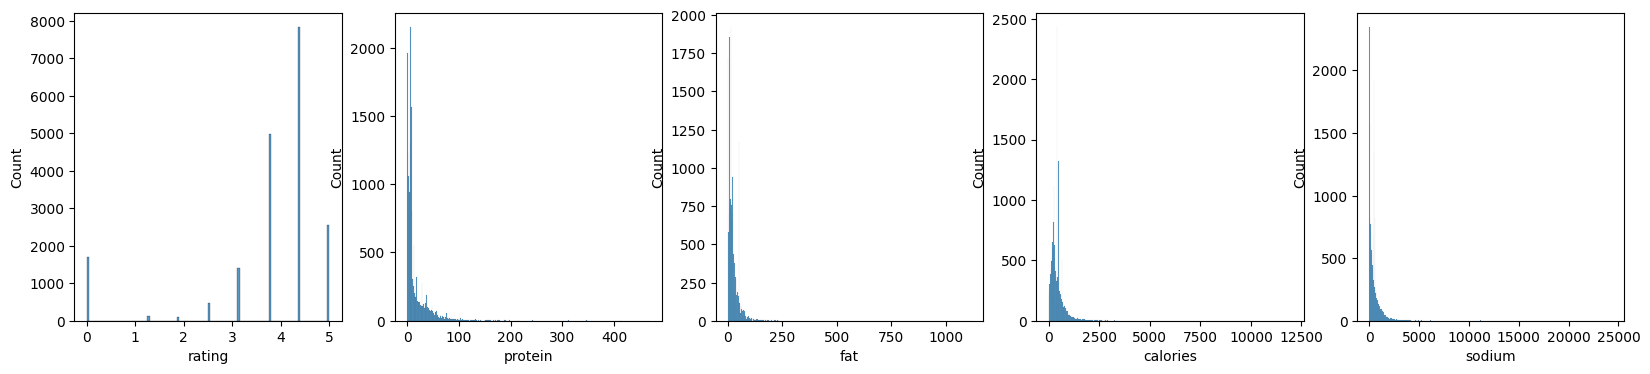

In [34]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 4))
sns.histplot(data=sorted_recipes, x='rating', ax=ax[0])
sns.histplot(data=sorted_recipes, x='protein', ax=ax[1])
sns.histplot(data=sorted_recipes, x='fat', ax=ax[2])
sns.histplot(data=sorted_recipes, x='calories', ax=ax[3])
sns.histplot(data=sorted_recipes, x='sodium', ax=ax[4])
plt.show()

### 5. Scatter plots between the numerical features

It is evident a boundary line in the scatterplots. The first one, calories vs fat, explicitly shows the strong correlation between these two features. It is not possible to have a recipe for any food where the amount of fat is too high and the overall calorie is low. They are linearly related. This also happens between protein and calorie but it is less accentuaded. Less explicitly, fat and protein also define a region of possible values for each of them.

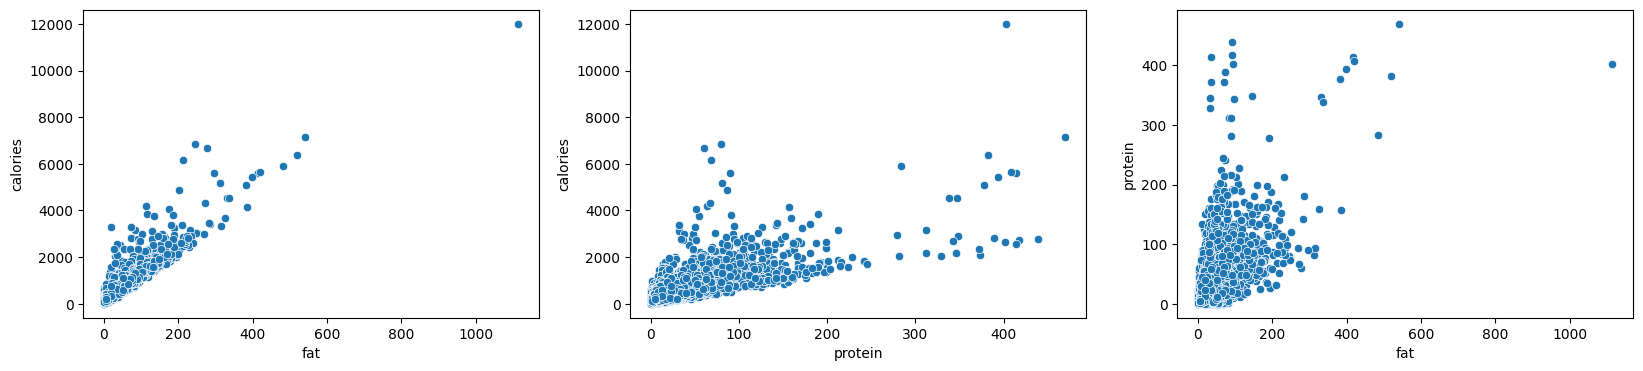

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 4))
sns.scatterplot(data=sorted_recipes, x='fat', y='calories', ax=ax[0])
sns.scatterplot(data=sorted_recipes, x='protein', y='calories',ax=ax[1])
sns.scatterplot(data=sorted_recipes, x='fat', y='protein', ax=ax[2])
plt.show()

### 6. Bucketizing the ratings to visualize some data considering intervals of ratings as categories.

Minimum value for rating is 0 and maximum is 5.
This way, we can define buckets of length 1.0 starting from 0.0 and going up to 5.0 inclusive.
Total of five categories for ratings.

In [36]:
recipes.rating.describe().transpose()

count    20111.000000
mean         3.713085
std          1.342793
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [37]:
bins = [.0, 1., 2., 3., 4., 5.]
labels = ['really bad', 'bad', 'normal', 'good', 'great']
recipes['bucket_rating'] = pd.cut(recipes['rating'], bins=bins, labels=labels, include_lowest=True)

In [38]:
recipes.sample(5)

,fat,calories,protein,rating,sodium,directions,categories,desc,title,ingredients,date,bucket_rating
17797,4.0,61.0,6.0,5.000,17.0,[Position rack in top third of oven and prehea...,"[Soup/Stew, turkey, Thanksgiving]","Though canned turkey broth is now available, h...",Homemade Turkey Stock,"[3 pounds turkey wings (about 3 large wings), ...",2007-10-03 19:41:19,great
10192,54.0,846.0,76.0,4.375,765.0,[Melt 3 tablespoons butter with oil in heavy l...,"[Fish, Mushroom, Bake, Trout, Bon Appétit]",Missing,Whole Baked Trout with Mushrooms,"[3 tablespoons butter, 3 tablespoons vegetable...",2004-08-20 04:00:00,great
8335,6.6,276.4,5.0,0.000,64.2,[Mix all ingredients in small bowl. Season to ...,"[Condiment/Spread, Sauce, Onion, Tomato, No-Co...",Missing,Tomato-Onion Topping,"[1 1/2 cups chopped tomatoes, 1/2 cup chopped ...",2004-08-20 04:00:00,really bad
10246,0.0,54.0,3.0,4.375,63.0,"[So long as you find the right snap peas, you'...","[Side, Low Fat, Kid-Friendly, Quick & Easy, Hi...",I admit that I'm hard on sugar snap peas. I ge...,Snap Pea Salad,"[1 pound sugar snap peas, trimmed and strings ...",2015-04-20 04:00:00,great
15175,10.0,148.0,4.0,3.125,55.0,"[Chop scallions, reserving white and dark gree...","[Garlic, Side, Sauté, Quick & Easy, St. Patric...",The leftover Savoy cabbage from our <epi:recip...,Sautéed Savoy Cabbage with Scallions and Garlic,"[1 bunch scallions, 2 garlic cloves, chopped, ...",2010-02-24 04:00:00,good


### 7. Recipes categories analysis

#### 7.1 To how many categories do each recipe belong?

In [39]:
recipes['num_categories'] = recipes.categories.map(lambda x: len(x))

In [40]:
cats = recipes[['categories', 'num_categories']]
cats.sample(5)

,categories,num_categories
5968,"[Soup/Stew, Ginger, Leafy Green, Vegetable, Lo...",11
2514,"[Herb, Appetizer, Bake, Cheddar, Winter, Gourmet]",6
15497,"[Salad, Fourth of July, Picnic, Quick & Easy, ...",20
8956,"[Fish, Quick & Easy, Mardi Gras, Kwanzaa, Spic...",7
10653,"[Condiment/Spread, Sauce, Mustard, Mayonnaise,...",5


In [41]:
cats.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
num_categories,20111.0,12.161752,5.093774,0.0,8.0,11.0,16.0,37.0


In [42]:
cats = cats.sort_values(by='num_categories', ascending=False)
cats.head()

,categories,num_categories
19362,"[Smoothie, Blender, Berry, Citrus, Fruit, Brea...",37
2676,"[Salad, Side, No-Cook, Fourth of July, Picnic,...",33
16780,"[Wine, Alcoholic, Berry, Dessert, Christmas, C...",33
13198,"[Salad, Cheese, Vegetable, Appetizer, Side, Ch...",33
6776,"[Bourbon, Champagne, Fruit Juice, Punch, Alcoh...",32


In [43]:
most_cats = cats.iloc[0,0]

In [44]:
most_cats = sorted(list(map(lambda x : x.lower(), most_cats)))

Even the recipe with the most amount of categories do not have repeated categories assigned. It is a good lead.

In [45]:
print(most_cats)

['banana', 'berry', 'blender', 'bon appétit', 'breakfast', 'citrus', 'dessert', 'drink', 'easter', "father's day", 'fourth of july', 'fruit', 'grapefruit', 'healthy', 'kosher', 'low fat', 'lunch', "mother's day", "new year's day", 'no-cook', 'orange', 'peach', 'peanut free', 'pescatarian', 'quick & easy', 'shower', 'smoothie', 'soy free', 'spring', 'strawberry', 'summer', 'tree nut free', 'tropical fruit', "valentine's day", 'vegetarian', 'wheat/gluten-free', 'yogurt']


The number of categories per recipe tends to be an approxitation of a normal distribution.

75% of the recipes have up to approximately 16 categories tagged to them as described earlier and confirmed in the boxplot.

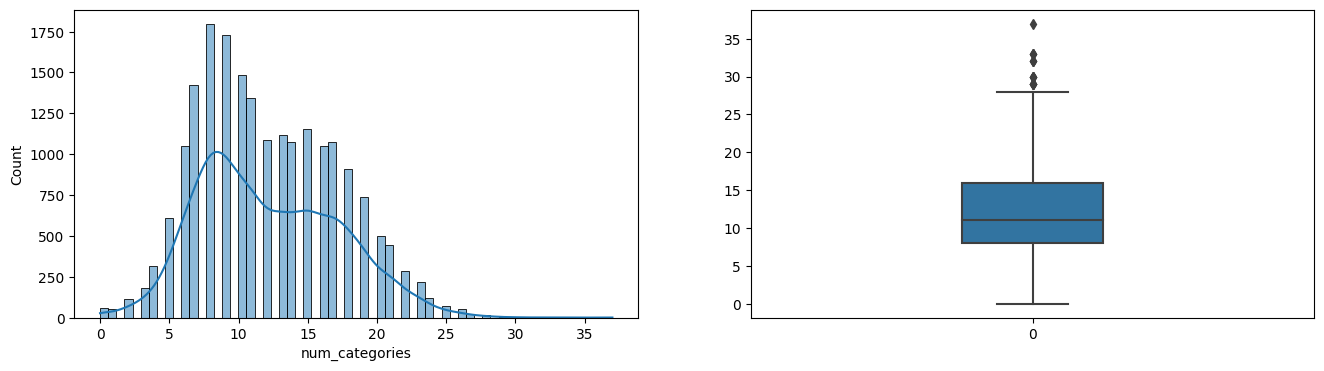

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
sns.histplot(cats.num_categories, kde=True, ax=ax[0])
sns.boxplot(cats.num_categories, ax=ax[1], width=.25)
plt.show()

#### 7.2 How is the relationship between the mean amount of categories a recipe has been tagged to and the ratings they have been assigned to?

The recipes that cover the more categories, receive better ratings. This could be indicating that it should be recommended to most people and evaluated mostly.

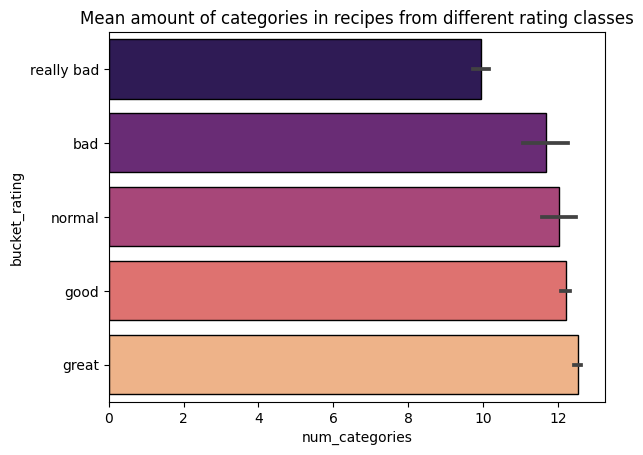

In [47]:
data = recipes[['rating', 'bucket_rating', 'num_categories']].sort_values(by='rating', ascending=True)
sns.barplot(data=data, x='num_categories', y='bucket_rating', edgecolor='black', palette='magma')
plt.title("Mean amount of categories in recipes from different rating classes")
plt.show()

#### 7.3 Time to explode...

Exploding the dataset in the categories feature should create multiple rows corresponding to the recipes but with only one of the their categories.

In [48]:
recipes_cats_exploded = recipes.explode('categories').rename(columns={'categories': 'categorie'})

In [49]:
recipes_cats_exploded.shape

(244644, 13)

The indexes from "recipes_cats_exploded" refer to the early 20111 recipes.

In [50]:
recipes_cats_exploded.categorie = recipes_cats_exploded.categorie.str.lower()

In [51]:
recipes_cats_exploded.sample(5)

,fat,calories,protein,rating,sodium,directions,categorie,desc,title,ingredients,date,bucket_rating,num_categories
8459,2.0,148.0,2.0,4.375,21.0,"[1. In a deep saucepan, bring the sugar, orang...",blueberry,Missing,Chilled Blueberry Soup,"[1/2 cup sugar, Juice of 1 orange (or 1/4 cup ...",2007-06-05 22:17:50,great,10
12499,51.0,827.0,10.0,3.750,890.0,"[Working in 2 batches, blend first 5 ingredien...",dried fruit,"For best results, use fresh ricotta, which is ...",Dried Cherry and Ginger Cannoli,"[4 cups (2 pounds) fresh ricotta cheese, 2 cup...",2004-11-30 19:00:18,good,16
19885,11.0,174.0,2.0,3.125,42.0,"[Preheat oven to 350°F., Toast almonds on a ba...",bake,Active time: 25 min Start to finish: 2 hr,Chocolate Coconut Almond Sprinkles,"[1/3 cup almonds with skins, finely chopped, 1...",2004-08-20 04:00:00,good,17
12874,18.0,225.0,10.0,4.375,240.0,"[Whisk lime zest, lime juice, mustard, and hon...",fall,Thinly sliced raw cauliflower takes center sta...,Shaved Cauliflower Salad,"[1 teaspoon finely grated lime zest, 1/4 cup f...",2016-09-30 17:40:00,great,12
8402,0.0,112.0,1.0,5.000,3.0,"[In a pitcher stir together the orange juice, ...",vegan,Missing,Orange Pineapple Refresher,"[4 cups fresh orange juice, 1 1/2 cups unsweet...",2004-08-20 20:58:12,great,18


Top 10 most tagged categories among the recipes. 

In [52]:
total_categories = pd.DataFrame(recipes_cats_exploded.categorie.value_counts()).rename(columns={'categorie': 'count'})
total_categories.head(10)

,count
bon appétit,9355
peanut free,8390
soy free,8088
tree nut free,7044
vegetarian,6846
gourmet,6648
kosher,6175
pescatarian,6042
quick & easy,5372
wheat/gluten-free,4906


Total of 59 recipes tagged with no categorie at all.

In [53]:
recipes.categories.value_counts().head(1)

[]    59
Name: categories, dtype: int64

Total of mentioned categories matches with the exploded recipes dataset. Therefore, the categories are themselves unique for each recipe.

In [54]:
recipes_cats_exploded.shape[0] - 59 == total_categories['count'].sum()

True

#### 7.4 How do the recipes marked with the most popular categorie behave in terms of fat and protein considering ratings?

In [55]:
bon_appetit_recipes = recipes_cats_exploded[recipes_cats_exploded.categorie == 'bon appétit']

Unique 'bon appétit' recipes.

In [56]:
bon_appetit_recipes.index.nunique() == bon_appetit_recipes.shape[0]

True

Grouping these recipes by `bucket_rating` and calculating the mean indeed gives us some insights...

In [57]:
data = bon_appetit_recipes.groupby('bucket_rating').mean(numeric_only=True)[['fat', 'protein']].reset_index()

In [58]:
data

,bucket_rating,fat,protein
0,really bad,15.224460,8.474101
1,bad,21.905618,10.743820
2,normal,21.709278,12.481443
3,good,155.071410,57.714428
4,great,163.600291,36.321733


The recipes tagged as 'bon appétit' suffer influence on their percentage of `fat`. The more the fat, the better the ratings. Proteins do not influence that hard for defining either good or great ratings, but recipes with greater amount of protein tend to be better than normal in ratings.

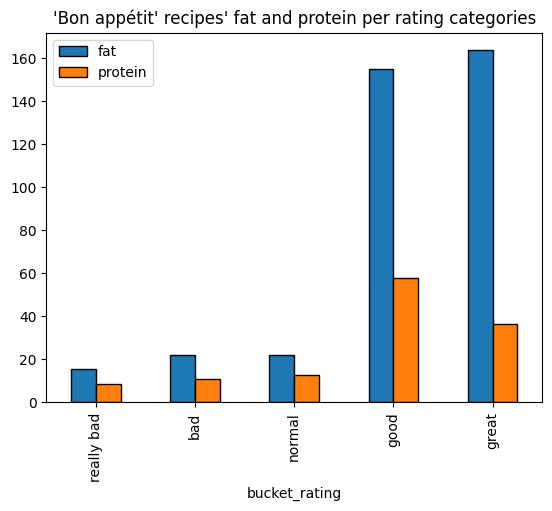

In [59]:
data.plot.bar(x='bucket_rating', edgecolor='black')
plt.title("'Bon appétit' recipes' fat and protein per rating categories")
plt.show()

#### 7.5 Through time, how did the popularity of the top10 categories evolved?

In [60]:
top10_categories = total_categories.head(10)

In [61]:
top10_categories = top10_categories.index.tolist()

In [62]:
print(top10_categories)

['bon appétit', 'peanut free', 'soy free', 'tree nut free', 'vegetarian', 'gourmet', 'kosher', 'pescatarian', 'quick & easy', 'wheat/gluten-free']


In [63]:
top10_cats_df = recipes_cats_exploded[['date', 'categorie']]

In [64]:
top10_cats_df = top10_cats_df[top10_cats_df.categorie.isin(top10_categories)]

In [65]:
top10_cats_df.sample(5)

,date,categorie
7609,2016-01-19 19:29:46.846000128,peanut free
7617,2013-10-08 04:00:00.000000000,quick & easy
4984,2004-08-20 12:48:48.000000000,quick & easy
6682,2004-08-20 04:00:00.000000000,bon appétit
11710,2004-08-20 04:00:00.000000000,tree nut free


In [66]:
def plot_popularity_evolution(data, ax, cat):
    data = pd.DataFrame(data.date.value_counts().reset_index().values, columns=['date', cat])
    data = data.sort_values(by='date', ascending=True)
    data[cat] = data[cat].cumsum()
    data.plot(kind='line', x='date', y=cat, ax=ax)

The register of recipes has only been significantly active since 2004. Thus the discontinuity is visible in this period of time in the graphic.

Gourmet was once the second most popular category but lost positions to 4 emergent ones. Apart from `quick & easy` (losing popularity in the competition with `kosher` and `pescatarian`) and `tree nut free` (winning competition versus `vegetarian` roughly in 2010) the rest of the top 10 most popular categories show very consistent evolution throughout the years.

Text(0.5, 1.0, 'Top 10 most popular categories evolution throughout the years')

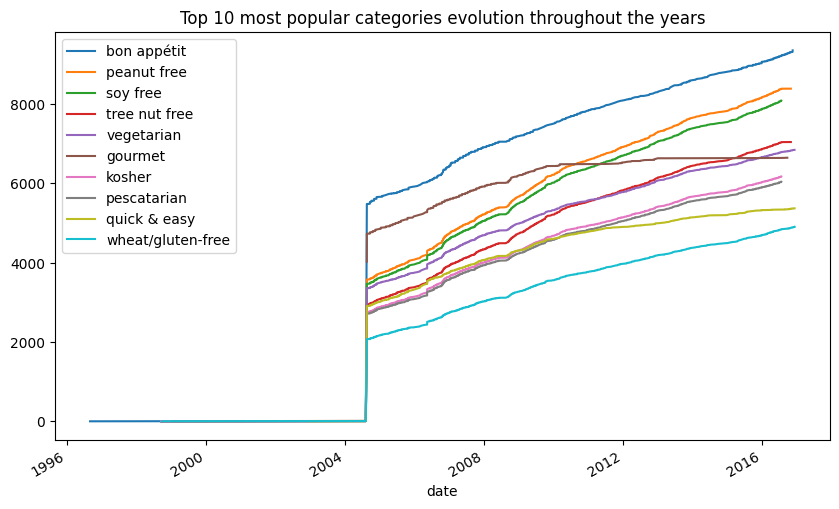

In [67]:
fig, ax = plt.subplots(figsize=(10,6))

for cat in top10_categories:
    plot_popularity_evolution(top10_cats_df[top10_cats_df.categorie == cat], ax, cat)

plt.title("Top 10 most popular categories evolution throughout the years")

#### 7.6 Among the top10 most popular categories, with whom do they get along well? 

This dataframe marks as `True` of `False` the presence of each categorie in each of the original recipes.

In [68]:
frequency_df = top10_cats_df.groupby([top10_cats_df.index, 'categorie']).size().unstack(fill_value=0)
frequency_df 

categorie,bon appétit,gourmet,kosher,peanut free,pescatarian,quick & easy,soy free,tree nut free,vegetarian,wheat/gluten-free
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,1,0,1,1,1,0,1,1,0,0
4,1,0,0,0,0,1,0,0,1,0
5,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
20106,0,1,0,0,0,0,0,0,0,0
20107,1,0,1,1,1,0,1,1,0,1
20108,0,1,0,1,0,0,1,1,0,0
20109,1,0,0,0,0,1,0,0,0,0


Multiplying this matrix with its transpose should give us a new matrix `10x10` of occurences of each categorie alongside the others.

In [69]:
dot_freq_mat = np.dot(frequency_df.T, frequency_df)

In [70]:
dot_freq_mat = pd.DataFrame(dot_freq_mat, index=top10_categories, columns=top10_categories)

This is the matrix represented as heatmap. We can see that recipes have been tagged as either `kosher` and `pescatarian` very frequently as we know kosher food frequently is made of fishes such as tuna and salmon.

This heatmap also suggests that soy free recipes combine well with tree nut free ones as they have been tagged together multiple times as well.

On the other hand, there is no highlighted partner for `gourmet` recipes, indicating that these recipes cover a wide variety of ingredients and styling for cooking.

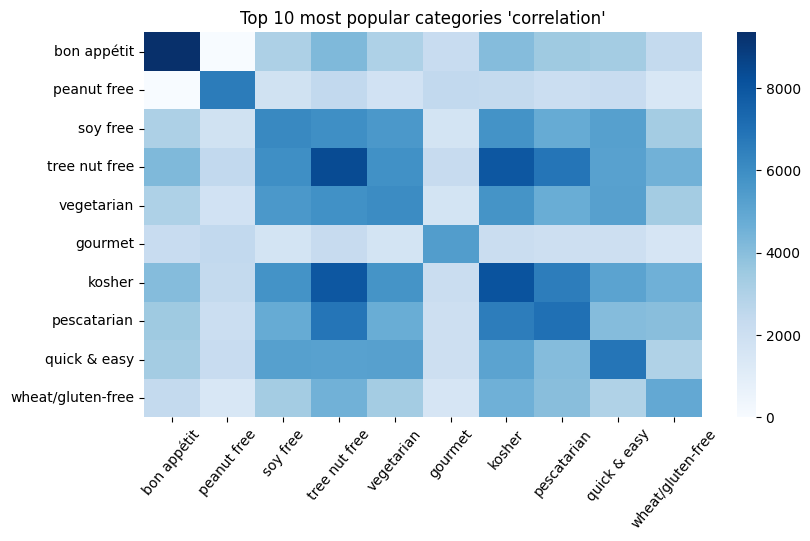

In [71]:
fig, ax = plt.subplots(figsize = (9,5))
sns.heatmap(dot_freq_mat, cmap="Blues")
plt.xticks(rotation=50)
plt.title("Top 10 most popular categories 'correlation'")
plt.show()

### 8. Can directions tell us anything?

Calculating the amount of directions for each recipe.

In [72]:
recipes_cats_exploded['num_directions'] = recipes_cats_exploded.directions.map(lambda x: len(x))
recipes['num_directions'] = recipes.directions.map(lambda x: len(x))

In [73]:
recipes.num_directions.describe()

count    20111.000000
mean         3.453732
std          2.339111
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         24.000000
Name: num_directions, dtype: float64

The histogram and boxplot tell us that approximately 75% of the recipes have something between 1 and 5 steps in order to be finished

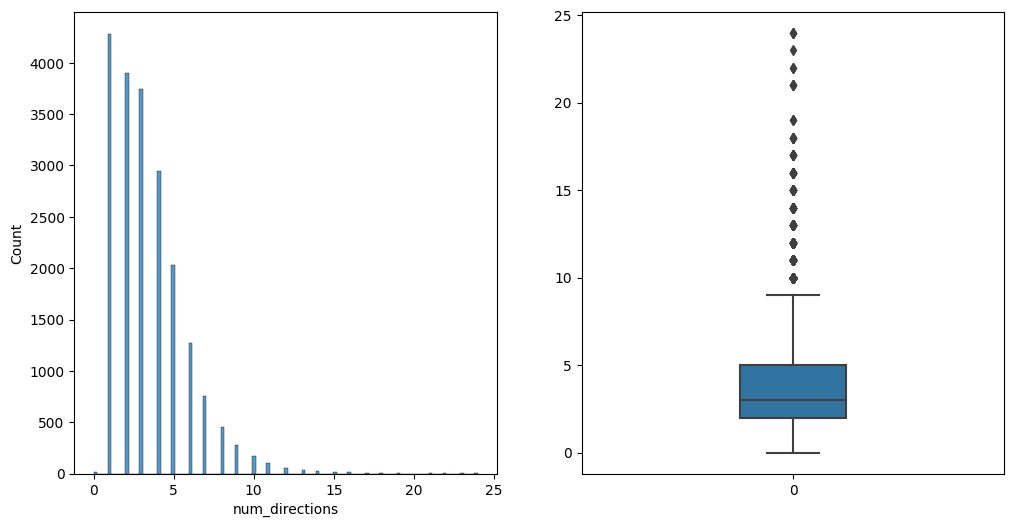

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
sns.histplot(recipes.num_directions, ax=ax[0])
sns.boxplot(recipes.num_directions, ax=ax[1], width=.25)
plt.show()

Direction example...

In [75]:
recipes.sort_values(by='num_directions', ascending=False).iloc[800,5]

['Preheat oven to 425°F. Whisk baking powder, salt, and 2 cups flour in a large bowl to combine. Using a pastry cutter or your fingers, work chilled butter into dry ingredients until mixture resembles coarse meal. Using a wooden spoon or fork, mix in sour cream and milk until a shaggy dough forms.',
 'Turn out dough onto a lightly floured surface and knead a few times just to bring together. Roll out until 1/4" thick, then fold in half. Roll dough out again until 1/4" thick, then fold in half again. Repeat once more, rolling out to a 3/4"-thick round.',
 'Punch out biscuits as close together as possible with cutter. Pat scraps together and punch out more biscuits; repeat until you can\'t cut out any more (you should have 12 total). Transfer biscuits to a parchment-lined baking sheet, spacing 1" apart, and bake, rotating sheet once, until golden brown and baked through, 10–12 minutes. Brush biscuits with melted butter.',
 'Dough can be made 1 day ahead. Cover and chill, or freeze up to 

#### 8.1 Considering that directions from the recipes define how extense is the recipe to be concretized, that should influence how well these recipes are rated.

The data tells us that great rated recipes tend to have a greater number of directions in order to fulfil it. The barplot below states that the greater the rating the greater is the mean number of guidance to the recipe reprodution. Perhaps, it gets easier to understand the step by step of the recipe and perform it, so the users rate these ones well.

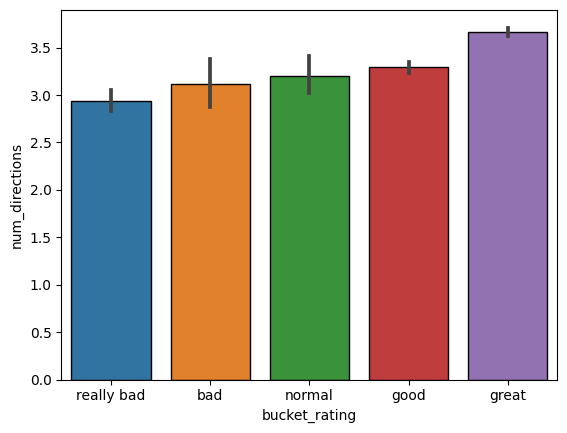

In [76]:
sns.barplot(data=recipes, x='bucket_rating', y='num_directions', edgecolor='black')
plt.show()

### 9. What are the recipe categories with the highest mean amount of protein but with the lowest amount of fat?

In [77]:
cats_properties = recipes_cats_exploded.groupby('categorie').mean(numeric_only=True)
cats_properties.sample(5)

,fat,calories,protein,rating,sodium,num_categories,num_directions
categorie,,,,,,,
dill,22.335793,385.340959,17.257565,3.775369,767.095203,12.756458,3.110701
kosher for passover,24.909677,396.864516,17.677419,3.286290,315.400000,15.064516,4.870968
stir-fry,26.111894,459.568282,21.504846,3.794053,800.940088,11.933921,3.405286
st. louis,40.857143,615.714286,31.285714,4.285714,1083.571429,9.571429,2.142857
yellow squash,15.360000,313.648000,7.336000,3.600000,399.264000,15.560000,3.320000


In [78]:
top50_highest_protein = cats_properties.sort_values(by='protein', ascending=False).head(50)

In [79]:
top5_high_protein_low_fat = top50_highest_protein.sort_values(by='fat', ascending=True).head(5)

In [80]:
top5_high_protein_low_fat = top5_high_protein_low_fat[['fat', 'protein']]

In [81]:
top5_high_protein_low_fat

,fat,protein
categorie,,
windsor,73.000000,389.000000
food processor,74.794450,184.223022
grill/barbecue,80.523007,184.402899
backyard bbq,80.541791,200.808529
tree nut free,89.665730,84.292561


Recipes contemplates with `windsor` categorie correspond to the ones with most protein and still low fat. These recipes might be interesting for bodybuilders or any one trying to be fitness and lose weight while winning body mass.

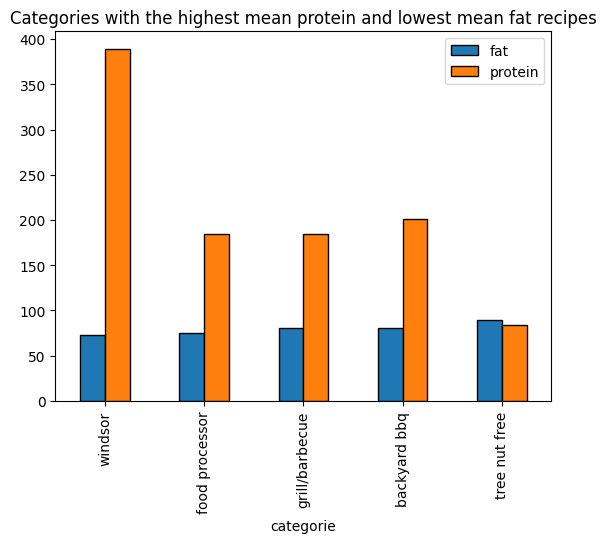

In [82]:
top5_high_protein_low_fat.plot.bar(y=['fat', 'protein'], edgecolor='black')
plt.title("Categories with the highest mean protein and lowest mean fat recipes")
plt.show()

### 10. Final comments

The description and title features were not used in this analysis as the other string/list data typed columns were more interesting to analyse and also combine further insights with the numerical ones. With more time, perhaps applying NLP into the `ingredients` feature could be useful to extract main ingredients in general and further analyse them in comparison to the categories.